<a id='intro'></a>
## Wrangle and analyze data from Twitter's WeRateDogs

[WeRateDogs](https://twitter.com/dog_rates) is a Twitter account dedicated to rating people's dogs along with humorous comments about them. It has millions of followers and has received international media coverage.  

Ratings have a denominator of 10, with numerators going up to greater than 10. Why? Because they're just good dogs. 

The primary goal of the exercise is to showcase my ability to assess the quality and tidiness of the WeRateDogs dataset, and clean them as necessary. 

The secondary goal is to create interesting analyses and visualizations (where available) from the data, such as the top 5 rated dog breeds.

As part of [Udacity's project](https://www.googleadservices.com/pagead/aclk?sa=L&ai=DChcSEwj_kre78-7wAhUqg0sFHX6nB8cYABACGgJzZg&ae=2&ohost=www.google.com&cid=CAESQeD2w0WLquSzk0z8gFE66RRWYWEHZTB2wXo0fDDSw0QJccmKjs4ruvfryHoG_r-henm22BD-sjVcGheE7QermcBC&sig=AOD64_3nngFz13JEQBeZ-5dAMWJAi6eojg&q&adurl&ved=2ahUKEwjM-6y78-7wAhWWyzgGHcdxC6UQ0Qx6BAgDEAE&dct=1), the Twitter archive of WeRateDogs was sent to Udacity and provided to me for use of this exercise. The archive contains data such as tweet ID, timestamp, and text, for records as of August 1st 2017. The archive was collated by Udacity and transformed into a dataframe in csv format with extracted information such as ratings, dog names, and dog stages (doggo, floofer, pupper etc). 

I am also provided with another dataset, courtesy of Udacity - a table of predicted dog breeds based off each dog Tweet's image via neural network and image recognition. 

A downside of the above already available datasets is some missing vital information such as retweet count and favourite count. These information may however be obtained from Twitter's API. As such, this exercise will also see me attempt to query Twitter's API to gather these information.

Let's get going!

---
## Table of Contents
- [Introduction](#intro)
- [Gather data](#gatherdata)
    - [Import 1st dataset through Pandas](#dataset1)
    - [Import 2nd dataset through Request](#dataset2)
    - [Import 3rd datasets through Tweepy](#dataset3)
- [Assess data](#assessdata)
    - [Quality](#quality)
    - [Tidiness](#tidiness)
- [Clean data for quality issues](#cleandata_quality)
- [Clean data for tidiness issues](#cleandata_tidiness)
- [Analyze data](#analyzedata)
- [Conclusion](#conclusion)

---
<a id='gatherdata'></a>
### Gather data

- A total of 3 datasets are required before I can begin assessing my data. 
- First is `twitter_archive_enhanced.csv`, which is WeRateDogs Twitter archive provided for  by Udacity.
- Second is `image_predictions.tsv`, which contains the tweet image predictions for dog breeds according to a neural network. It is hosted on Udacity servers and should be downloaded programmatically using the **Requests** library from this [link](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv). 
- Third and finally, each tweet's retweet count and favourite count (and any other data I find interesting). I will be using Twitter's API to query these data, which I will then store in `tweet_json.txt`, line by line.

<a id='dataset1'></a>
#### Import 1st dataset through Pandas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
twitter_archive_df = pd.read_csv('./data/twitter-archive-enhanced.csv')
print(f"There is a total of {len(twitter_archive_df)} tweets from the archive")

There is a total of 2356 tweets from the archive


In [4]:
# View first few rows
twitter_archive_df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


<a id='dataset2'></a>
#### Import 2nd dataset through Request

In [5]:
import requests

In [6]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [7]:
response # Successful

<Response [200]>

In [8]:
response.encoding

'utf-8'

In [9]:
# Read url content into csv file above
with open('./data/dogs-image-predictions.csv', mode='wb') as file:
    file.write(response.content)

In [10]:
# Import newly saved data separated by \t
image_predictions_df = pd.read_csv('./data/dogs-image-predictions.csv', sep='\t')
print(f"There is a total of {len(image_predictions_df)} tweet predictions")

There is a total of 2075 tweet predictions


Take note that there are fewer tweet predictions to the tweets in the archive.

<a id='dataset3'></a>
#### Import 3rd dataset through Tweepy

- I will be using [Tweepy](https://docs.tweepy.org/en/latest/getting_started.html), which is an open source Python library used to querying and accessing Twitter's data directly on Python. 
- I found this [article](https://www.geeksforgeeks.org/python-status-object-in-tweepy/) to be particularly useful in helping me understand how to access the attributes from the API object

In [11]:
import tweepy

consumer_key = 'private'
consumer_secret = 'private'
access_token = 'private'
access_secret = 'private'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

Test a single query from any random twitter id from the datasets above.

In [12]:
tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True).get_status(892420643555336193)

Status(_api=<tweepy.api.API object at 0x7f85dd405f40>, _json={'created_at': 'Tue Aug 01 16:23:56 +0000 2017', 'id': 892420643555336193, 'id_str': '892420643555336193', 'text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU", 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}, 'ex

We can see that the retweet and favourite counts are stored under `retweet_count` and `favorite_count`

In [13]:
api_results = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True).get_status(891815181378084864)

In [14]:
api_results.id

891815181378084864

In [15]:
api_results.retweet_count

3585

In [16]:
api_results.favorite_count

22655

- Use a loop to store all ids, retweet counts and favorite counts into a text file, `tweet_json.txt`, line by line
- Read data into a csv file

In [17]:
from collections import defaultdict
from tqdm import tqdm

In [18]:
# Get a list of all unique twitter ids from the first dataset
unique_twitter_id = twitter_archive_df['tweet_id'].unique().tolist()

In [ ]:
# Query and store results
file = open('./data/tweet_json.txt', 'w')

for i, j in tqdm(list(enumerate(unique_twitter_id))):
    try:
        api_results = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True).get_status(j)
        if i != 2355: # last id
            file.write(str(api_results.id) + '/' + str(api_results.retweet_count) + '/' + str(api_results.favorite_count) + '\n')
        else:
            file.write(str(api_results.id) + '/' + str(api_results.retweet_count) + '/' + str(api_results.favorite_count))
            
    except:
        print(f"Tweet id {x} cannot be found on Twitter anymore")
        pass

file.close()

In [19]:
# Read in the results above into a csv file
twitter_api_df = pd.read_csv('./data/tweet_json.txt', header=None, sep='/', names=['tweet_id', 'retweet_count', 'favorite_count'])
twitter_api_df.head(3)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7279,34735
1,892177421306343426,5445,30116
2,891815181378084864,3584,22664


Alright, now I have my datasets: `twitter_archive_df`, `image_predictions_df` and `twitter_api_df`

I will now be assessing them. But first, I will consolidate the data into a single, final dataframe as `twitter_combined_df` (as opposed to assessing the datasets individually and separately, then later combining them).

---

<a id='assessdata'></a>
### Assess data

Look at the first few rows of each dataset.

In [20]:
twitter_archive_df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [21]:
image_predictions_df.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [22]:
twitter_api_df.head(3)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7279,34735
1,892177421306343426,5445,30116
2,891815181378084864,3584,22664


Check if the number of unique tweet IDs diff between the datasets.

In [23]:
print(f"No. of unique IDs in the 1st dataset: {twitter_archive_df['tweet_id'].nunique()}")
print(f"No. of unique IDs in the 2nd dataset: {image_predictions_df['tweet_id'].nunique()}")
print(f"No. of unique IDs in the 3rd dataset: {twitter_api_df['tweet_id'].nunique()}")

No. of unique IDs in the 1st dataset: 2356
No. of unique IDs in the 2nd dataset: 2075
No. of unique IDs in the 3rd dataset: 2330


All datasets have different number of unique IDs. 

Nevertheless, **I will combine all datasets into one**, using `tweet_id` as the merging identifier.

In [24]:
twitter_combined_df = pd.merge(left=twitter_archive_df, right=image_predictions_df, on='tweet_id', how='outer')
twitter_combined_df = pd.merge(left=twitter_combined_df, right=twitter_api_df, on='tweet_id', how='outer')

assert len(twitter_combined_df) == twitter_combined_df['tweet_id'].nunique()

len(twitter_combined_df)

2356

In [25]:
twitter_combined_df = twitter_combined_df.reset_index().drop(['index'], axis=1)

In [26]:
twitter_combined_df.tail(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,...,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,38.0,105.0
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,...,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,41.0,117.0
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,...,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,440.0,2333.0


In [27]:
twitter_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

I don't understand what some columns stand for: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`. 

Let's explore them.

According to this [Twitter documentation](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet), `in_reply_to_status_id` indicates whether or not the tweet is a reply to an original tweet. Same goes with `retweeted_status_id` as to whether the tweet is a retweet of an original tweet.

In [28]:
twitter_combined_df[['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
                     'retweeted_status_user_id']].notnull().sum()

in_reply_to_status_id        78
in_reply_to_user_id          78
retweeted_status_id         181
retweeted_status_user_id    181
dtype: int64

In [125]:
twitter_combined_df[twitter_combined_df['in_reply_to_status_id'].notnull()][['tweet_id', 'text', 'in_reply_to_status_id']].head(3)

,tweet_id,text,in_reply_to_status_id
30,886267009285017600,@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,8.862664e+17
55,881633300179243008,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,8.816070e+17
64,879674319642796034,@RealKentMurphy 14/10 confirmed,8.795538e+17


In [126]:
twitter_combined_df[twitter_combined_df['retweeted_status_id'].notnull()][['tweet_id', 'text', 'retweeted_status_id']].head(3)

,tweet_id,text,retweeted_status_id
19,888202515573088257,RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17
32,886054160059072513,RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17
36,885311592912609280,RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17


**Looks like we do have retweets and replies.**

Check if all denominators are 10.

In [31]:
twitter_combined_df['rating_denominator'].unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

**Looks like we do have rating denominators that are not 10.**

Were they correctly extracted from the `text` column?

In [130]:
twitter_combined_df['text'].head()

0                                                         This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1    This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
2                     This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
3                                                               This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
4    This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f
Name: text, dtype: object

The texts are not being displayed in full.

In [33]:
pd.options.display.max_colwidth = 200

In [34]:
# Check texts of strange denominators
twitter_combined_df.query('rating_denominator != 10')[['text', 'rating_denominator']]

,text,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0
342,@docmisterio account started on 11/15/15,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50


From above, **it seems like the denominators were extracted incorrectly.** 

The good news is that we only have a relative handful of wrong ones. 

Check if there are dogs with more than one dog stage. I'd assume that each dog should only be in a single, unique stage.

In [35]:
(twitter_combined_df['doggo'] + ',' + twitter_combined_df['floofer'] + ',' + twitter_combined_df['pupper'] + ',' + \
twitter_combined_df['puppo']).unique()

array(['None,None,None,None', 'doggo,None,None,None',
       'None,None,None,puppo', 'None,None,pupper,None',
       'None,floofer,None,None', 'doggo,None,None,puppo',
       'doggo,floofer,None,None', 'doggo,None,pupper,None'], dtype=object)

**Some dogs have more than one stage assigned.**

Check if the TRUE dog breed predictions are indeed, proper dog breeds.

In [36]:
p1_examine = twitter_combined_df.groupby(['p1_dog']).apply(lambda x: x['p1'].unique()).reset_index().rename(columns = {0:'unique breeds'})
p2_examine = twitter_combined_df.groupby(['p2_dog']).apply(lambda x: x['p2'].unique()).reset_index().rename(columns = {0:'unique breeds'})
p3_examine = twitter_combined_df.groupby(['p3_dog']).apply(lambda x: x['p3'].unique()).reset_index().rename(columns = {0:'unique breeds'})

It seems like all of dog breeds as predicted by the first algorithm are indeed dog breeds

In [132]:
print(f"These are the unique dog breeds as predicted by algorithm #1")
p1_examine.loc[1, 'unique breeds'].tolist()

These are the unique dog breeds as predicted by algorithm #1


['Chihuahua',
 'basset',
 'Chesapeake_Bay_retriever',
 'Appenzeller',
 'Pomeranian',
 'Irish_terrier',
 'Pembroke',
 'Samoyed',
 'French_bulldog',
 'golden_retriever',
 'whippet',
 'Siberian_husky',
 'Mexican_hairless',
 'kuvasz',
 'pug',
 'Blenheim_spaniel',
 'Labrador_retriever',
 'malamute',
 'Italian_greyhound',
 'chow',
 'German_shepherd',
 'Doberman',
 'Eskimo_dog',
 'Weimaraner',
 'Saluki',
 'miniature_pinscher',
 'German_short-haired_pointer',
 'English_springer',
 'vizsla',
 'Irish_setter',
 'bloodhound',
 'Bernese_mountain_dog',
 'West_Highland_white_terrier',
 'cocker_spaniel',
 'flat-coated_retriever',
 'Cardigan',
 'Newfoundland',
 'Shetland_sheepdog',
 'komondor',
 'kelpie',
 'Greater_Swiss_Mountain_dog',
 'Border_collie',
 'bull_mastiff',
 'Staffordshire_bullterrier',
 'Lakeland_terrier',
 'Australian_terrier',
 'Bedlington_terrier',
 'Boston_bull',
 'Old_English_sheepdog',
 'black-and-tan_coonhound',
 'Great_Dane',
 'Yorkshire_terrier',
 'schipperke',
 'Airedale',
 'gia

In [38]:
print(f"These are the unique non-dog items as predicted by algorithm #1")
p1_examine.loc[0, 'unique breeds'].tolist()

These are the unique non-dog items as predicted by algorithm #1


['orange',
 'paper_towel',
 'limousine',
 'convertible',
 'web_site',
 'tusker',
 'street_sign',
 'tricycle',
 'tabby',
 'laptop',
 'basketball',
 'home_theater',
 'comic_book',
 'pole',
 'marmot',
 'Arabian_camel',
 'syringe',
 'envelope',
 'lakeside',
 'chimpanzee',
 'Angora',
 'revolver',
 'grille',
 'barbell',
 'prison',
 'barrow',
 'pencil_box',
 'car_mirror',
 'tennis_ball',
 'patio',
 'fountain',
 'coffee_mug',
 'sea_lion',
 'white_wolf',
 'washer',
 'tub',
 'ice_bear',
 'military_uniform',
 'teapot',
 'swing',
 'birdhouse',
 'toilet_tissue',
 'shopping_cart',
 'mortarboard',
 'leopard',
 'wooden_spoon',
 'hyena',
 'ox',
 'bath_towel',
 'jersey',
 'seat_belt',
 'hippopotamus',
 'teddy',
 'gas_pump',
 'dingo',
 'cowboy_boot',
 'bathtub',
 'school_bus',
 'acorn_squash',
 'dishwasher',
 'restaurant',
 'doormat',
 'Siamese_cat',
 'loupe',
 'shield',
 'bookcase',
 'minivan',
 'mousetrap',
 'vacuum',
 'dough',
 'pedestal',
 'bakery',
 "jack-o'-lantern",
 'refrigerator',
 'remote_contr

Similarly, the second and third algorithms also seemed to predict dog breeds as indeed, dog breeds.

In [39]:
p2_examine.loc[1, 'unique breeds'].tolist()

['Pekinese',
 'malamute',
 'Labrador_retriever',
 'English_springer',
 'Irish_terrier',
 'Border_collie',
 'Eskimo_dog',
 'Irish_setter',
 'Cardigan',
 'Pomeranian',
 'boxer',
 'borzoi',
 'Tibetan_mastiff',
 'Rhodesian_ridgeback',
 'pug',
 'redbone',
 'toy_terrier',
 'Great_Pyrenees',
 'Chihuahua',
 'Shih-Tzu',
 'Siberian_husky',
 'American_Staffordshire_terrier',
 'Norwich_terrier',
 'French_bulldog',
 'malinois',
 'miniature_pinscher',
 'Chesapeake_Bay_retriever',
 'Afghan_hound',
 'beagle',
 'vizsla',
 'Boston_bull',
 'whippet',
 'collie',
 'golden_retriever',
 'Welsh_springer_spaniel',
 'Italian_greyhound',
 'Saint_Bernard',
 'Pembroke',
 'Staffordshire_bullterrier',
 'miniature_poodle',
 'black-and-tan_coonhound',
 'bloodhound',
 'Sussex_spaniel',
 'flat-coated_retriever',
 'briard',
 'Appenzeller',
 'kuvasz',
 'papillon',
 'groenendael',
 'Airedale',
 'toy_poodle',
 'Tibetan_terrier',
 'Doberman',
 'otterhound',
 'Brabancon_griffon',
 'Bernese_mountain_dog',
 'bull_mastiff',
 'Ma

<a id='quality'></a>
#### Quality

1. `timestamp` should be a datetime object
2. There are non-original tweets (retweets, replies to tweets)
3. Some `rating_denominator` values were not extracted properly
4. Some dogs have more than one dog stage assigned to them
5. `doggo`, `floofer`, `pupper` and `puppo` can be better labelled with Boolean values 
6. Dog breeds `p1`, `p2` and `p3` not spelled consistently
7. The prediction confidences `p1_conf`, `p2_conf` and `p3_conf` should be in percentages
8. `retweet_count` and `favorite_count` should be in integers, not floats

<a id='tidiness'></a>
#### Tidiness

1. Values in `doggo`, `floofer`, `pupper` and `puppo` should be consolidated into a single column
2. Three different algorithms were used to predict each dog breed, each recording how confident the algo was in its prediction. To simplify the analysis and presentation of the dataset, the dog breed that has the highest confidence should be chosen to represent each dog. If no dog breeds were given, it should be indicated that the algo was not able to predict the dog breed. 

---
<a id='cleandata_quality'></a>
### Clean data - Quality issues

In [40]:
twitter_clean = twitter_combined_df.copy()

In [41]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### Define: 

> 1) `timestamp` should be a datetime object

- The `timestamp` column has the wrong datatype. Convert it into a datetime object

#### Code

In [42]:
twitter_clean['Date'] = pd.to_datetime(pd.to_datetime(twitter_clean['timestamp']).apply(lambda x: x.date()))
twitter_clean['Time'] = pd.to_datetime(twitter_clean['timestamp']).apply(lambda x: x.time())

twitter_clean.drop(['timestamp'], axis=1, inplace=True)

#### Test

In [43]:
twitter_clean.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,Date,Time
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,...,bagel,0.085851,False,banana,0.076110,False,7279.0,34735.0,2017-08-01,16:23:56
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,...,Pekinese,0.090647,True,papillon,0.068957,True,5445.0,30116.0,2017-08-01,00:17:27
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,...,malamute,0.078253,True,kelpie,0.031379,True,3584.0,22664.0,2017-07-31,00:18:03


In [44]:
twitter_clean['Date'].dtype

dtype('<M8[ns]')

#### Define: 

> 2) There are non-original tweets (retweets, replies to tweets)

- I will remove tweets where their `retweet_count` and `favorite_count` values are not null

#### Code

In [45]:
twitter_clean[['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
               'retweeted_status_user_id']].notnull().sum()

in_reply_to_status_id        78
in_reply_to_user_id          78
retweeted_status_id         181
retweeted_status_user_id    181
dtype: int64

In [46]:
# Only want to retain tweets where the above columns are null
for i in ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id']: 
    twitter_clean = twitter_clean[twitter_clean[i].isnull()]

#### Test

In [47]:
twitter_clean[['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
               'retweeted_status_user_id']].notnull().sum()

in_reply_to_status_id       0
in_reply_to_user_id         0
retweeted_status_id         0
retweeted_status_user_id    0
dtype: int64

In [48]:
# How many tweets are left?
print(f"From {len(twitter_combined_df)} tweets to {len(twitter_clean)} tweets remaining")

From 2356 tweets to 2097 tweets remaining


In [49]:
# Drop these columns (not necessary anymore)
twitter_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id'],
                   axis=1, inplace=True)

#### Define: 

> 3) Some `rating_denominator` values were not extracted properly

- If you look at the table below, we see some ratings that were extracted from the first xx/xx pattern, which is not actually the dog rating (for example, index 1662 and 2335).
- For the above, I would need to use Regex to extract such patterns, and select only the second set of ratings as my numerator and denominator. 
- For the remaining mistakes, I'm not too sure if the ratings were actually meant to signify the dog ratings...or something else. 
- After browsing through them (for example, index 902, 1351, 1779), I think I would just remove them.

In [50]:
twitter_clean.query('rating_denominator != 10')[['text', 'rating_denominator']]

,text,rating_denominator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",50


#### Code

In [51]:
rating_tofix = twitter_clean.query('rating_denominator != 10')[['text', 'rating_denominator']]

In [52]:
import re

# Create new columns to store newly extracted ratings
rating_tofix['Correct_rating'] = ''
rating_tofix['New_denominator'] = ''
rating_tofix['New_numerator'] = ''

# Extract the correct ratings
for i,j in rating_tofix.iterrows():
    try:
        first = re.findall(r"\d+[/]\d+", j['text'])[0]
        second = re.findall(r"\d+[/]\d+", j['text'])[1]
        rating_tofix.loc[i, 'Correct_rating'] = second
    except:
        pass

# Split ratings into numerator and denominator
rating_tofix['New_numerator'], rating_tofix['New_denominator'] = rating_tofix['Correct_rating'].str.split('/').str
rating_tofix = rating_tofix.fillna('')

<ipython-input-52-30e8b23c4d2b>:18: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  rating_tofix['New_numerator'], rating_tofix['New_denominator'] = rating_tofix['Correct_rating'].str.split('/').str


Now, we have the correct ratings for tweets where the first pattern was initially taken to be the dog rating, which was wrong.

In [53]:
rating_tofix

,text,rating_denominator,Correct_rating,New_denominator,New_numerator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70,,,
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7,,,
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150,,,
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11,14/10,10,14
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170,,,
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20,13/10,10,13
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,11/10,10,11
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90,,,
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,,,
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",50,,,


I will now replace the new denominators and numerators to the original dataframe `twitter_clean`.

I will also remove the other lines where I am unsure of whether or not their ratings refer to dog ratings.

In [54]:
# Value replacement
for i in [1068, 1165, 1202, 1662, 2335]:
    twitter_clean.loc[i, 'rating_numerator'] = rating_tofix.loc[i, 'New_numerator']
    twitter_clean.loc[i, 'rating_denominator'] = rating_tofix.loc[i, 'New_denominator']

In [55]:
# Remove lines
for i in [433, 516, 902, 1120, 1228, 1254, 1274, 1351, 1433, 1635, 1779, 1843]:
    twitter_clean = twitter_clean.drop(i)

In [56]:
# The extracted ratings were in a string format
twitter_clean['rating_denominator'] = twitter_clean['rating_denominator'].astype(int)
twitter_clean['rating_numerator'] = twitter_clean['rating_numerator'].astype(int)

#### Test

In [57]:
# New denominators
twitter_clean['rating_denominator'].unique()

array([10])

In [58]:
# Old, original denominators
twitter_combined_df['rating_denominator'].unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [59]:
# New numerators
twitter_clean['rating_numerator'].unique()

array([  13,   12,   14,    5,   11,    6,   10,    0,   75,   27,    3,
          7,    8,    9,    4, 1776,   26,    2,    1,  420])

In [60]:
# Old numerators
twitter_combined_df['rating_numerator'].unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

#### Define: 

> 4) Some dogs have more than one dog stage assigned to them

- For tweets with more than one stage assigned, I need to look at The Dogtionary and their pictures to re-classify them.

#### Code

We see some with the doggo and floofer types, some with doggo and puppo types, some with doggo and pupper.

In [61]:
(twitter_clean['doggo'] + ',' + twitter_clean['floofer'] + ',' + twitter_clean['pupper'] + ',' + \
twitter_clean['puppo']).unique()

array(['None,None,None,None', 'doggo,None,None,None',
       'None,None,None,puppo', 'None,None,pupper,None',
       'None,floofer,None,None', 'doggo,None,None,puppo',
       'doggo,floofer,None,None', 'doggo,None,pupper,None'], dtype=object)

In [62]:
# Create a temporary column to store the combinations
twitter_clean['dog_stage'] = twitter_clean['doggo'] + ',' + twitter_clean['floofer'] + ',' + \
                             twitter_clean['pupper'] + ',' + twitter_clean['puppo']

In [63]:
# Get a general count of tweets that I'd need to manually re-classify
twitter_clean.groupby(['dog_stage'])['tweet_id'].count()

dog_stage
None,None,None,None        1749
None,None,None,puppo         23
None,None,pupper,None       221
None,floofer,None,None        9
doggo,None,None,None         72
doggo,None,None,puppo         1
doggo,None,pupper,None        9
doggo,floofer,None,None       1
Name: tweet_id, dtype: int64

So, it looks like a total of 11 tweets need fixing.

It also just dawned on me that there are 1,749 tweets without dog stages. 

**I will look at these later.**

In [64]:
# Get all tweet IDs of dogs that need to have their stages checked
twitter_clean.groupby('dog_stage')['tweet_id'].unique().reset_index()[5:]

,dog_stage,tweet_id
5,"doggo,None,None,puppo",[855851453814013952]
6,"doggo,None,pupper,None","[817777686764523521, 808106460588765185, 801115127852503040, 785639753186217984, 781308096455073793, 759793422261743616, 751583847268179968, 741067306818797568, 733109485275860992]"
7,"doggo,floofer,None,None",[854010172552949760]


In [65]:
# Get a list of the above tweet IDs and their images
tweet_id_fix = {}

for i,j in twitter_clean.groupby('dog_stage')['tweet_id'].unique().reset_index()[5:].iterrows():
    for a in j['tweet_id']:
        tweet_id_fix[a] = twitter_clean.query('tweet_id == @a')['jpg_url'].values[0]
        
pd.DataFrame(tweet_id_fix, index=[0]).transpose()

,0
855851453814013952,https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg
817777686764523521,https://pbs.twimg.com/ext_tw_video_thumb/817777588030476288/pu/img/KbuLpE4krHF4VdPf.jpg
808106460588765185,https://pbs.twimg.com/media/Czb4iFRXgAIUMiN.jpg
801115127852503040,https://pbs.twimg.com/media/Cx4h7zHUsAAqaJd.jpg
785639753186217984,https://pbs.twimg.com/media/CucnLmeWAAALOSC.jpg
781308096455073793,NaN
759793422261743616,https://pbs.twimg.com/media/CotUFZEWcAA2Pku.jpg
751583847268179968,https://pbs.twimg.com/media/Cm4phTpWcAAgLsr.jpg
741067306818797568,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg
733109485275860992,https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg


Ok, let's go through the above image urls to determine each dog stage.

Results:
- ID 855851453814013952 = puppo
- ID 817777686764523521 = puppo
- ID 808106460588765185 = doggo, pupper
- ID 801115127852503040 = pupper
- ID 785639753186217984 = None
- ID 781308096455073793 = None
- ID 759793422261743616 = doggo, pupper
- ID 751583847268179968 = doggo
- ID 741067306818797568 = doggo, pupper
- ID 733109485275860992 = doggo, pupper
- ID 854010172552949760 = snoot

Some have pictures of 2 dogs, and I had thought of classifying them as `family`, to see if perhaps pictures of more than one dog have higher ratings than the rest, but considering I would only have less than 10 of these, it wouldn't add any significance to the analysis. So, I will just group these under `doggo`.

In [66]:
# Manually change them

# doggo first: 808106460588765185, 759793422261743616, 751583847268179968, 741067306818797568, 733109485275860992
for i in [808106460588765185, 759793422261743616, 751583847268179968, 741067306818797568, 733109485275860992]:
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'doggo'] = 'doggo'
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'floofer'] = 'None'
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'pupper'] = 'None'
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'puppo'] = 'None'

# floofer second: -

# pupper third: 801115127852503040
for i in [801115127852503040]:
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'doggo'] = 'None'
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'floofer'] = 'None'
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'pupper'] = 'pupper'
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'puppo'] = 'None'

# puppo last: 855851453814013952, 817777686764523521
for i in [855851453814013952, 817777686764523521]:
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'doggo'] = 'None'
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'floofer'] = 'None'
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'pupper'] = 'None'
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'puppo'] = 'puppo'

# none: 785639753186217984, 781308096455073793, 854010172552949760
for i in [785639753186217984, 781308096455073793, 854010172552949760]:
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'doggo'] = 'None'
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'floofer'] = 'None'
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'pupper'] = 'None'
    twitter_clean.loc[twitter_clean.query('tweet_id == @i').index, 'puppo'] = 'None'

Let's check out those with no dog stages at all. 

Considering these infomation were extracted from each tweet's text, it may be that in actuality, none of these words may be found in the text itself, or perhaps something else is going on.

In [67]:
twitter_clean.query('dog_stage == "None,None,None,None"')['text'].to_frame().head(40)

,text
0,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV"
2,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
3,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
4,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f"
5,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh
6,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl
7,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq
8,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b
10,This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme


Hmm, from the above lines, a majority of tweets do in fact not have any of the key words of doggo, pupper, puppo etc.

I am also not sure how these dog stages were classified by Udacity, but I'd assume (from the table below) that they only used these direct matches to classify the dog stages for each tweet. 

However, we do see words like pup in the table above, which I am presuming was not used as one of the direct matches. 

Assuming that pup refers to pupper, let's see how many new dog stages I will get if pup is used.

In [68]:
twitter_clean.query('dog_stage != "None,None,None,None"')['text'].to_frame().head(20)

,text
9,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A
12,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm
14,This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq
29,This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen immediate. 12/10 deep breaths Roscoe https://t.co/RGE08MIJox
43,Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ
46,Meet Grizzwald. He may be the floofiest floofer I ever did see. Lost eyes saving a schoolbus from a volcano erpuption. 13/10 heroic as h*ck https://t.co/rf661IFEYP
49,This is Gus. He's quite the cheeky pupper. Already perfected the disinterested wink. 12/10 would let steal my girl https://t.co/D43I96SlVu
56,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
71,This is Snoopy. He's a proud #PrideMonthPuppo. Impeccable handwriting for not having thumbs. 13/10 would love back #PrideMonth https://t.co/lNZwgNO4gS
82,This is Ginger. She's having a ruff Monday. Too many pupper things going on. H*ckin exhausting. 12/10 would snug passionately https://t.co/j211oCDRs6


In [69]:
# Use pup as another direct word match
pup_check = twitter_clean.query('dog_stage == "None,None,None,None"')['text'].to_frame()
(pup_check['text'].str.contains('pup', case=False)).sum()

245

Looks like I'd have an additional 245 lines that would have otherwise been designated as a pupper. 

I will go ahead with this fix!

In [70]:
pup_fix = pup_check[pup_check['text'].str.contains('pup', case=False)]

twitter_clean.loc[pup_fix.index, 'pupper'] = 'pupper'   

#### Test

In [71]:
# Before, we had
twitter_clean['dog_stage'].value_counts()

None,None,None,None        1749
None,None,pupper,None       221
doggo,None,None,None         72
None,None,None,puppo         23
None,floofer,None,None        9
doggo,None,pupper,None        9
doggo,None,None,puppo         1
doggo,floofer,None,None       1
Name: dog_stage, dtype: int64

In [72]:
# Now:
(twitter_clean['doggo'] + ',' + twitter_clean['floofer'] + ',' + \
twitter_clean['pupper'] + ',' + twitter_clean['puppo']).value_counts()

None,None,None,None       1507
None,None,pupper,None      467
doggo,None,None,None        77
None,None,None,puppo        25
None,floofer,None,None       9
dtype: int64

In [73]:
# Drop dog_stage
twitter_clean.drop(['dog_stage'], axis=1, inplace=True)

#### Define: 

> 5) `doggo`, `floofer`, `pupper` and `puppo` can be better labelled with Boolean values

- Map non-null values as 1 and null values as 0

#### Code

In [74]:
twitter_clean['doggo'] = twitter_clean['doggo'].map({'None':0, 'doggo':1})
twitter_clean['floofer'] = twitter_clean['floofer'].map({'None':0, 'floofer':1})
twitter_clean['pupper'] = twitter_clean['pupper'].map({'None':0, 'pupper':1})
twitter_clean['puppo'] = twitter_clean['puppo'].map({'None':0, 'puppo':1})

#### Test

In [75]:
twitter_clean[['doggo', 'floofer', 'pupper', 'puppo']].value_counts()

doggo  floofer  pupper  puppo
0      0        0       0        1507
                1       0         467
1      0        0       0          77
0      0        0       1          25
       1        0       0           9
dtype: int64

#### Define: 

> 6) Dog breeds `p1`, `p2` and `p3` not spelled consistently

- Some have underscores as spaces, some have first letters as uppercase whereas some are in lowercase.
- I will standardize all of them to have underscores as spaces, and all lowercase letters throughout

#### Code

In [76]:
for i in ['p1', 'p2', 'p3']:
    twitter_clean[i] = twitter_clean[i].str.replace(' ', '_').str.replace('-', '_').str.lower()


#### Test

In [133]:
# Brief look through of all predictions
twitter_clean['p1'].value_counts().to_frame().reset_index().sort_values('index', ascending=True).head(10)

,index,p1
166,acorn_squash,2
134,afghan_hound,3
225,african_crocodile,1
335,african_grey,1
309,african_hunting_dog,1
256,agama,1
36,airedale,12
318,alp,1
365,american_black_bear,1
34,american_staffordshire_terrier,13


In [135]:
# Brief look through of all dog breed predictions
twitter_clean.query('p1_dog == True')['p1'].value_counts().to_frame().reset_index().sort_values('index', ascending=True).head(10)

,index,p1
94,afghan_hound,3
33,airedale,12
27,american_staffordshire_terrier,13
97,appenzeller,2
100,australian_terrier,2
58,basenji,7
31,basset,13
22,beagle,17
68,bedlington_terrier,5
38,bernese_mountain_dog,10


#### Define: 

> 7) The prediction confidences `p1_conf`, `p2_conf` and `p3_conf` should be in percentages

- Multiply all confidence scores by 100, and round them up to 2 decimal place, and make sure they are stored as floats

In [79]:
# Check for any missing values
print(f"There are {(twitter_clean['p1_conf'].isnull()).sum()} null confidence values in the 1st algo")
print(f"There are {(twitter_clean['p2_conf'].isnull()).sum()} null confidence values in the 2nd algo")
print(f"There are {(twitter_clean['p3_conf'].isnull()).sum()} null confidence values in the 3rd algo")

There are 126 null confidence values in the 1st algo
There are 126 null confidence values in the 2nd algo
There are 126 null confidence values in the 3rd algo


In [80]:
# Fill missing values with 0
twitter_clean['p1_conf'].fillna(0, inplace=True)
twitter_clean['p2_conf'].fillna(0, inplace=True)
twitter_clean['p3_conf'].fillna(0, inplace=True)

In [81]:
for i in ['p1_conf', 'p2_conf', 'p3_conf']:
    twitter_clean[i] = twitter_clean[i].apply(lambda x: round(x*100, 2))

#### Test

In [82]:
twitter_clean[['p1_conf', 'p2_conf', 'p3_conf']].head()

,p1_conf,p2_conf,p3_conf
0,9.70,8.59,7.61
1,32.36,9.06,6.90
2,71.60,7.83,3.14
3,17.03,16.81,4.08
4,55.57,22.58,17.52


In [83]:
twitter_clean[['p1_conf', 'p2_conf', 'p3_conf']].dtypes

p1_conf    float64
p2_conf    float64
p3_conf    float64
dtype: object

#### Define: 

> 8) retweet_count and favorite_count should be in integers, not floats

- Convert datatype

In [84]:
# Check for missing data
twitter_clean['retweet_count'].isnull().sum()

7

In [85]:
twitter_clean['favorite_count'].isnull().sum()

7

In [86]:
# Fill in missing data with 0
twitter_clean['retweet_count'].fillna(0, inplace=True)
twitter_clean['favorite_count'].fillna(0, inplace=True)

In [87]:
# Change datatypes
twitter_clean['retweet_count'] = twitter_clean['retweet_count'].astype(int)
twitter_clean['favorite_count'] = twitter_clean['favorite_count'].astype(int)

#### Test

In [88]:
twitter_clean[['retweet_count', 'favorite_count']].dtypes

retweet_count     int64
favorite_count    int64
dtype: object

---
<a id='cleandata_tidiness'></a>
### Clean data - Tidiness issues

#### Define: 

> 1) Values in `doggo`, `floofer`, `pupper` and `puppo` should be consolidated into a single column

In [89]:
# Confirm each tweet has a single stage atttributed to it
(twitter_clean['doggo'] + twitter_clean['floofer'] + twitter_clean['pupper'] + twitter_clean['puppo']).unique()

array([0, 1])

In [90]:
# Define function
def aggregate_dogs(df):
    if df['doggo'] == 1:
        return 'doggo'
    elif df['floofer'] == 1:
        return 'floofer'
    elif df['pupper'] == 1:
        return 'pupper'
    elif df['puppo'] == 1:
        return 'puppo'
    else:
        return 'none'

In [91]:
# Call function and store results in new column
twitter_clean['dog_stage'] = twitter_clean.apply(aggregate_dogs, axis=1)

#### Test

In [92]:
twitter_clean['dog_stage'].value_counts() # Similar to numbers obtained in previous assessments

none       1507
pupper      467
doggo        77
puppo        25
floofer       9
Name: dog_stage, dtype: int64

In [93]:
# Drop unnecessary columns
twitter_clean.drop(['doggo', 'pupper', 'puppo', 'floofer'], axis=1, inplace=True)

#### Define: 

> 2) Three different algorithms were used to predict each dog breed, each recording how confident the algo was in its prediction. To simplify the analysis and presentation of the dataset, the dog breed that has the highest confidence should be chosen to represent each dog. If no dog breeds were given, it should be indicated that the algo was not able to predict the dog breed. 

- The end result is to have a single column with the highest accuracy predicted dog breed. 
- If no dog breeds were predicted -> `None`
- If dog breeds were predicted, store the one with the highest confidence accuracy.

#### Code

The idea is that I'd create a list that stores all the tweet IDs as keys, and p1, p1_dog, and p1_conf values as values of their respective keys. 

After doing so, I will search though all values for whether or not 

- `True` is in the string value. 

If no - store another value `None` in a new dictionary that corresponds to that tweet ID. 
If yes - use Regex to get all prediction accuracies, and select the dog breed that corresponds to the higher prediction accuracy. Store the breed in the new dictionary that corresponds to its tweet ID.

Feed the new values to a new column of the dataframe.

In [94]:
from collections import defaultdict

prediction_accuracy_list = defaultdict(list)

for i,j in twitter_clean.iterrows():
    prediction_accuracy_list[j['tweet_id']].append(str(j['p1_dog']) + ',' + str(j['p1']) + ',' + str(j['p1_conf']))
    prediction_accuracy_list[j['tweet_id']].append(str(j['p2_dog']) + ',' + str(j['p2']) + ',' + str(j['p2_conf']))
    prediction_accuracy_list[j['tweet_id']].append(str(j['p3_dog']) + ',' + str(j['p3']) + ',' + str(j['p3_conf']))

In [96]:
# Loop through each list item
results_dog_breed = {}

for i in prediction_accuracy_list:
    values = prediction_accuracy_list[i] # Get all values (True/False, dog breed, prediction accuracy)
    joined_values = '/'.join(values) # Join all elements together into a single string
    if 'True' not in joined_values: # If none of the predictions had a dog breed, append 'None'
        results_dog_breed[i] = 'None'
    elif 'True' in joined_values: 
        # If at least one of the 3 algos predicted a dog breed, search for the breed with the highest accuracy
        joined_values_true_only = '/'.join(re.findall(r"True,\w+,\d+[\.]\d+", joined_values)) # Get True only elements
        accuracy = re.findall(r"(?<=,)(\d+[.]\d+)", joined_values_true_only) # Extract all accuracies
        accuracy_float = [float(i) for i in accuracy] # Convert accuracies from string to float
        highest_accuracy = np.max(accuracy_float) # Get max value across all accuracy values
        dog_breed_highest_accuracy = re.findall(rf"(?<=True,)(.*?)(?=,{highest_accuracy})", joined_values_true_only) # Get breed with highest accuracy
        results_dog_breed[i] = dog_breed_highest_accuracy[0]
    else:
        print(f"Tweet ID {i} has no prediction result")

In [97]:
# Store it in the dataframe
twitter_clean['dog_breed'] = ''

for i,j in twitter_clean.iterrows():
    twitter_clean.loc[i, 'dog_breed'] = results_dog_breed[j['tweet_id']]

#### Test

In [98]:
twitter_clean['dog_breed'].value_counts()

None                    430
golden_retriever        154
labrador_retriever      103
pembroke                 94
chihuahua                90
                       ... 
japanese_spaniel          1
entlebucher               1
bouvier_des_flandres      1
scotch_terrier            1
irish_wolfhound           1
Name: dog_breed, Length: 114, dtype: int64

Let's look at random tweets to check if the if else loop above worked as intended.

In [99]:
sample_tweets = twitter_clean.sample(10)

In [100]:
sample_tweets[['p1', 'p1_dog', 'p1_conf', 'p2', 'p2_dog', 'p2_conf', 'p3', 'p3_dog', 'p3_conf', 'dog_breed']]

,p1,p1_dog,p1_conf,p2,p2_dog,p2_conf,p3,p3_dog,p3_conf,dog_breed
1455,pug,True,99.74,bull_mastiff,True,0.17,pekinese,True,0.03,pug
1279,schipperke,True,74.56,kelpie,True,16.79,boston_bull,True,1.48,schipperke
1271,shetland_sheepdog,True,79.75,collie,True,5.41,keeshond,True,3.17,shetland_sheepdog
1285,chihuahua,True,74.82,toy_terrier,True,12.77,pembroke,True,4.21,chihuahua
1305,chihuahua,True,88.85,italian_greyhound,True,8.86,toy_terrier,True,1.59,chihuahua
1750,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,None
354,cocker_spaniel,True,26.33,brittany_spaniel,True,20.05,doormat,False,19.34,cocker_spaniel
145,eskimo_dog,True,41.33,malamute,True,34.76,siberian_husky,True,14.95,eskimo_dog
1276,siberian_husky,True,21.30,eskimo_dog,True,17.89,labrador_retriever,True,17.42,siberian_husky
1436,great_dane,True,17.40,malinois,True,16.59,doberman,True,11.99,great_dane


Yay!

---
<a id='analyzedata'></a>
### Analyze data

Time to analyze our cleaned data!

I have never ever analyzed anything that even remotely resembles dog-related data...so let's see. 

1. How have the number of retweets and favorites changed over time? 
2. How do the different dog stages fare in their retweet and favorite counts?
3. Is there a correlation between dog ratings, and the retweet and favorite counts?

> How have the number of retweets and favorites changed over time?

Let's look at the timeline of all the tweets.

In [101]:
twitter_clean['Date'].describe()

<ipython-input-101-a8e8298698ca>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  twitter_clean['Date'].describe()


count                    2085
unique                    598
top       2015-11-29 00:00:00
freq                       26
first     2015-11-15 00:00:00
last      2017-08-01 00:00:00
Name: Date, dtype: object

First tweet on our WeRateDogs data was recorded in 2015, with the latest extracted tweet in 2017.

In [102]:
og_tweet_year_count = twitter_clean['Date'].dt.year.value_counts().to_frame().reset_index()
og_tweet_year_count = og_tweet_year_count.rename(columns = {'index':'tweet_year','Date':'original_tweet_count'})
og_tweet_year_count = og_tweet_year_count.sort_values('tweet_year')
og_tweet_year_count

,tweet_year,original_tweet_count
1,2015,666
0,2016,1045
2,2017,374


2016 saw the largest amount of tweets, before decreasing to a mere 374 in 2017. 

However, it is important to note that we have removed some tweets on the basis that they do not have the correct ratings, so the actual number of most recent tweets may perhaps be higher than what we are seeing. They just do not meet our data standards.

What about the number of retweets and favorites over the years?

In [103]:
retweet_year_count = twitter_clean.groupby(twitter_clean['Date'].dt.year)['retweet_count'].sum().to_frame().reset_index()
retweet_year_count = retweet_year_count.rename(columns = {'Date':'tweet_year'})
retweet_year_count

,tweet_year,retweet_count
0,2015,614596
1,2016,2515336
2,2017,1853025


In [104]:
fav_year_count = twitter_clean.groupby(twitter_clean['Date'].dt.year)['favorite_count'].sum().to_frame().reset_index()
fav_year_count = fav_year_count.rename(columns = {'Date':'tweet_year'})
fav_year_count

,tweet_year,favorite_count
0,2015,1500110
1,2016,7305954
2,2017,7892561


In [105]:
analysis_1 = pd.concat([og_tweet_year_count, retweet_year_count, fav_year_count], axis=1)
analysis_1 = analysis_1.loc[:, ~analysis_1.columns.duplicated()].sort_values('tweet_year') # Drop duplicated tweet_year columns
analysis_1

,tweet_year,original_tweet_count,retweet_count,favorite_count
1,2015,666,2515336,7305954
0,2016,1045,614596,1500110
2,2017,374,1853025,7892561


Let's plot a line graph to look at the changes in numbers from 2015 to 2017 for each variable.

In [106]:
# Convert datatype of tweet_year from an integer to categorical data
analysis_1['tweet_year'] = analysis_1['tweet_year'].astype(str).astype('category')

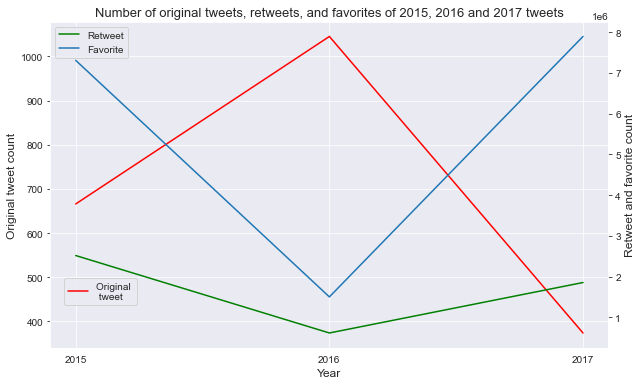

In [107]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlabel('Year', size=12)
ax.grid(b=None)
plt.title('Number of original tweets, retweets, and favorites of 2015, 2016 and 2017 tweets', size=13)

# Bar chart - primary y axis
ax.plot(analysis_1['tweet_year'], analysis_1['original_tweet_count'], color='red', label='Original \n tweet')
ax.set_ylabel('Original tweet count', size=12)
ax.legend(bbox_to_anchor = [0.165, 0.23])

# Line chart - secondary y axis
ax2 = ax.twinx()
ax2.plot(analysis_1['tweet_year'], analysis_1['retweet_count'], color='green', label='Retweet')
ax2.plot(analysis_1['tweet_year'], analysis_1['favorite_count'], label='Favorite')
ax2.set_ylabel('Retweet and favorite count', size=12)
ax2.legend();


We see that when the numbers are proportionately scaled in the visualisation as above, 2016 indeed saw the highest number of original, unique tweets on WeRateDogs, before dropping significantly in 2017. 

However, although the number of original tweets decreased in 2017, 2017 saw an increase in the number of retweets and favorites. 

Perhaps the dogs posted on WeRateDogs in 2016 were not as appealing or worthy of retweets or favorites as compared to dogs posted in 2015 and 2017. 

Let's look at the average ratings given to dogs of 2015, 2016 and 2017.

In [108]:
# Look at list of ratings
twitter_clean['rating_numerator'].value_counts()

12      486
10      437
11      414
13      288
9       153
8        98
7        51
14       39
5        34
6        32
3        19
4        15
2         9
1         4
0         1
27        1
1776      1
420       1
26        1
75        1
Name: rating_numerator, dtype: int64

Since there are clear outliers in the rating numerators, I will use `median` as the summary statistic.

In [109]:
twitter_clean.groupby(twitter_clean['Date'].dt.year)['rating_numerator'].median()

Date
2015    10
2016    11
2017    13
Name: rating_numerator, dtype: int64

It does look like dogs of 2017 had a higher median rating than 2015 and 2016.

What about the trend of tweet counts at a more granular level (ie without aggregating the counts to a year by year basis - retaining it on a day by day basis)

In [139]:
og_tweet_date_count = twitter_clean['Date'].value_counts().to_frame().reset_index()
og_tweet_date_count = og_tweet_date_count.rename(columns = {'index':'tweet_date','Date':'original_tweet_count'})
og_tweet_date_count = og_tweet_date_count.sort_values('tweet_date')
og_tweet_date_count.head(3)

,tweet_date,original_tweet_count
213,2015-11-15,3
2,2015-11-16,25
20,2015-11-17,15


In [137]:
retweet_date_count = twitter_clean.groupby(twitter_clean['Date'])['retweet_count'].sum().to_frame().reset_index()
retweet_date_count = retweet_date_count.rename(columns = {'Date':'tweet_date'})
retweet_date_count.head(3)

,tweet_date,retweet_count
0,2015-11-15,519
1,2015-11-16,8916
2,2015-11-17,1904


In [138]:
fav_date_count = twitter_clean.groupby(twitter_clean['Date'])['favorite_count'].sum().to_frame().reset_index()
fav_date_count = fav_date_count.rename(columns = {'Date':'tweet_date'})
fav_date_count.head(3)

,tweet_date,favorite_count
0,2015-11-15,2555
1,2015-11-16,19039
2,2015-11-17,4111


In [140]:
analysis_1b = pd.concat([og_tweet_date_count, retweet_date_count, fav_date_count], axis=1)
analysis_1b = analysis_1b.loc[:, ~analysis_1b.columns.duplicated()].sort_values('tweet_date') # Drop duplicated tweet_year columns
analysis_1b.head()

,tweet_date,original_tweet_count,retweet_count,favorite_count
213,2015-11-15,3,6890,21663
2,2015-11-16,25,1904,4111
20,2015-11-17,15,7128,17285
13,2015-11-18,17,14742,35155
3,2015-11-19,23,3311,7612


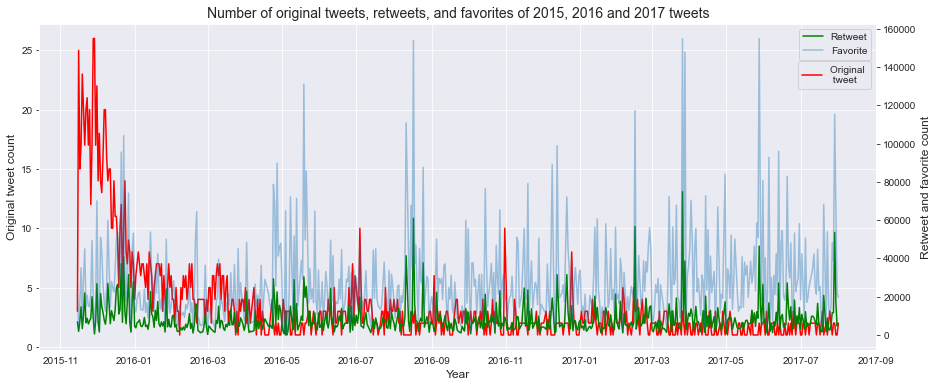

In [114]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(15,6))

ax.set_xlabel('Year', size=12)
ax.grid(b=None)
plt.title('Number of original tweets, retweets, and favorites of 2015, 2016 and 2017 tweets', size=14)

# Bar chart - primary y axis
ax.plot(analysis_1b['tweet_date'], analysis_1b['original_tweet_count'], color='red', label='Original \n tweet')
ax.set_ylabel('Original tweet count', size=12)
ax.legend(bbox_to_anchor = [1, 0.9])

# Line chart - secondary y axis
ax2 = ax.twinx()
ax2.plot(analysis_1b['tweet_date'], analysis_1b['retweet_count'], color='green', label='Retweet')
ax2.plot(analysis_1b['tweet_date'], analysis_1b['favorite_count'], label='Favorite', alpha=0.4)
ax2.set_ylabel('Retweet and favorite count', size=12)
ax2.legend();

I would not be able to draw any conclusions from the above chart, other than being able to observe that the number of daily tweets posted on WeRateDogs were significantly higher in the final quarter of 2015, after which the frequency decreased dramatically. From the middle of 2016 onwards, other than the occational spikes in number of daily tweets, the average number of daily tweets on WeRateDogs was below 5. 

It does not look like there is a correlation between the number of daily original tweets and the number of daily retweets and favorites, suggesting that something else about these tweets are attracting retweets and favourites (some attractive factor that was mising from the earlier 2015 and beginning 2016 tweets).

Or it could be simply arbituary.

> How do the different dog stages fare in their retweet and favorite counts?

In [115]:
twitter_clean['dog_stage'].value_counts()

none       1507
pupper      467
doggo        77
puppo        25
floofer       9
Name: dog_stage, dtype: int64

Note that a majority of tweets do not have any dog stage attributed to them, while `pupper` had a larger share of attribution than the other dog stages.

In [116]:
avg_retweet_dog_stage = twitter_clean.groupby('dog_stage')['retweet_count'].mean().to_frame().reset_index()
avg_retweet_dog_stage = avg_retweet_dog_stage.rename(columns = {'retweet_count':'average_retweet_count'})
avg_retweet_dog_stage.query('dog_stage != "none"').sort_values('average_retweet_count')

,dog_stage,average_retweet_count
3,pupper,2052.612420
1,floofer,3455.111111
0,doggo,5590.805195
4,puppo,5936.480000


In [117]:
avg_fav_dog_stage = twitter_clean.groupby('dog_stage')['favorite_count'].mean().to_frame().reset_index()
avg_fav_dog_stage = avg_fav_dog_stage.rename(columns = {'favorite_count':'average_fav_count'})
avg_fav_dog_stage.query('dog_stage != "none"').sort_values('average_fav_count')

,dog_stage,average_fav_count
3,pupper,7152.584582
1,floofer,9679.666667
0,doggo,16525.532468
4,puppo,20639.080000


We see that eventhough `pupper` had the largest share of twitted dogs, they had the lowest average retweet and favorite counts. 

On the other hand, `puppo` only had 25 tweets, but had the highest average retweet and favorite counts.

Does `puppo` also have the highest ratings?

In [118]:
twitter_clean.groupby('dog_stage')['rating_numerator'].median().to_frame().reset_index().rename(columns = {'rating_numerator':'median_rating'})


,dog_stage,median_rating
0,doggo,12
1,floofer,12
2,none,11
3,pupper,11
4,puppo,12


In [119]:
twitter_clean.groupby('dog_stage')['rating_numerator'].mean().to_frame().reset_index().rename(columns = {'rating_numerator':'mean_rating'})



,dog_stage,mean_rating
0,doggo,11.766234
1,floofer,11.888889
2,none,12.016589
3,pupper,10.631692
4,puppo,12.080000


Seems like it! 

`puppo` has the highest median and mean ratings as compared to the other dog stages!

In [120]:
twitter_clean.query('dog_stage == "puppo"')['dog_breed'].value_counts() # puppo dog breeds

eskimo_dog                        3
labrador_retriever                3
golden_retriever                  3
None                              2
flat_coated_retriever             1
cardigan                          1
chow                              1
american_staffordshire_terrier    1
airedale                          1
italian_greyhound                 1
miniature_pinscher                1
german_shepherd                   1
curly_coated_retriever            1
lakeland_terrier                  1
pembroke                          1
old_english_sheepdog              1
malamute                          1
rottweiler                        1
Name: dog_breed, dtype: int64

> Is there a correlation between dog ratings, and the retweet and favorite counts?

I am going to remove the outlier ratings (those above 50) so that my visualisations are not skewed.

In [121]:
twitter_clean['rating_numerator'].unique()

array([  13,   12,   14,    5,   11,    6,   10,    0,   75,   27,    3,
          7,    8,    9,    4, 1776,   26,    2,    1,  420])

In [122]:
twitter_clean_analysis3 = twitter_clean.query('rating_numerator <= 50')
twitter_clean_analysis3['rating_numerator'].unique()

array([13, 12, 14,  5, 11,  6, 10,  0, 27,  3,  7,  8,  9,  4, 26,  2,  1])

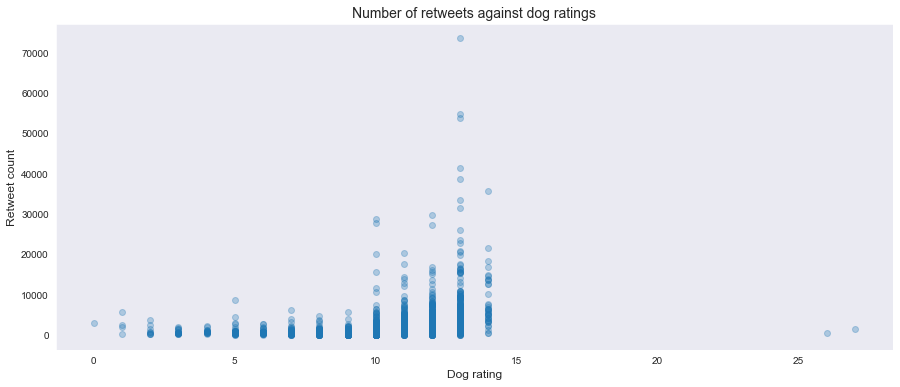

In [123]:
plt.subplots(figsize=(15,6))
plt.scatter(twitter_clean_analysis3['rating_numerator'], twitter_clean_analysis3['retweet_count'], alpha=0.3)
plt.title('Number of retweets against dog ratings', size=14)
plt.xlabel('Dog rating', size=12)
plt.ylabel('Retweet count', size=12);

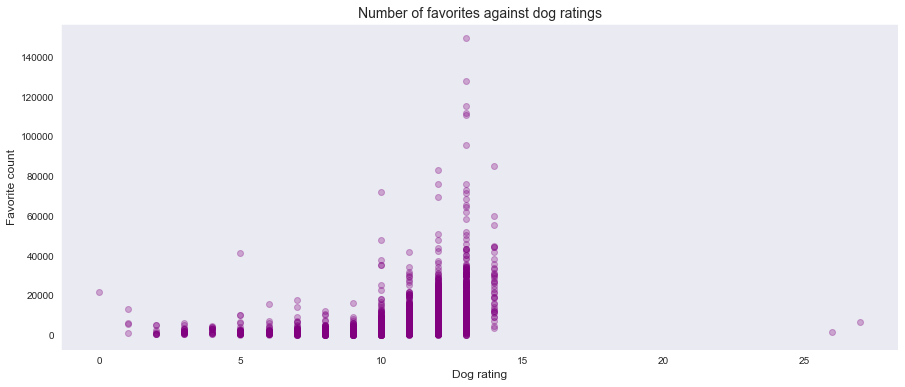

In [124]:
plt.subplots(figsize=(15,6))
plt.scatter(twitter_clean_analysis3['rating_numerator'], twitter_clean_analysis3['favorite_count'], color='purple', alpha=0.3)
plt.title('Number of favorites against dog ratings', size=14)
plt.xlabel('Dog rating', size=12)
plt.ylabel('Favorite count', size=12);


Generally, we do see that the higher a given dog rating, the higher the retweets and favorites.

---
<a id='conclusion'></a>
### Conclusion

Because EDA was only performed, I was not able to formalize any conclusion from this dataset, other than observing some trends and patterns from it. Some interesting insights that I observed are:

1) The earlier dog tweets (2015) did not have the **wow** factor that should have led to a similar proportion of larger volume retweets and favorites, as compared to tweets of 2016 and 2017.

2) Many factors may contribute to the above phenomenon, such as perhaps the dogs posted in 2015 were not appealing enough to the WeRateDogs audience, or there was less recognition of such dog tweets in the first place in 2015, or it might also be that retweets and favorites were just not a thing back then. 

3) We can see that the hype in posting dog tweets on WeRateDogs had also dwindled across the years, remaining at a consistently low volume of posts in 2016 and 2017. 

4) Puppos had the highest retweets, favorites and ratings, and dogs with higher ratings usually garnered the highest retweets and favorites too. However, I cannot say what the reasons are for the fluctuating retweet and favorite counts - are they driven by the appearance of particular dog stages? Dog breeds? Judged dog ratings? Unless some sort of a regression analysis is carried out, one can only speculate. And even then - correlation does not mean causation.

---